In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

In [32]:
from scipy.stats import norm

sigma = 1
cost = 0.1
# high value of planning: sigma=30, c=0.01
# medium value of planning: sigma=28, c=1.00
# low value of planning: sigma=1, c=4.00

def make_env(sigma=sigma, cost=cost, discretization=None):
    if discretization:
        d = norm(0, sigma)
        vals = np.linspace(-2*sigma, 2*sigma, n)
        delta = vals[1] - vals[0]
        bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
        probs = np.diff(d.cdf(bins))
        reward = Categorical(vals, probs)
    else:
        reward = Normal(0, sigma)
    # vals = [-5, -1, 1, 5]
    # probs = [.1, .4, .4, .1]
    # reward = Categorical(vals, probs)
    return MouselabEnv([3, 3, 3, 3], reward=reward, cost=cost,
                       ground_truth=[0, *reward.sample(250)])

def make_envs(seed=0, n=50):
    np.random.seed(seed)
    return [make_env() for _ in range(n)]

envs = make_envs(0)
TERM = envs[0].term_action
print(envs[0].reward)

Norm(0.00, 1.00)


In [3]:
import json
def save_envs(envs):
    data = [{'stateRewards': e.ground_truth.tolist()} for e in envs]
    with open('../experiments/exp1/static/json/med_cost.json', 'w+') as f:
        json.dump(data, f)
    with open('../webppl-mouselab/med_cost.json', 'w+') as f:
        json.dump(data, f)
        
save_envs(envs)

In [33]:
from policies import MouselabPolicy
from skopt import gp_minimize
bounds = [ (-30., 30.) ] * 5
agent = Agent()

def evaluate(policy, envs):
    def run_env(policy, env):
        agent.register(policy)
        agent.register(env)
        tr = agent.run_episode()
        return {'util': tr['return'],
                'observations': len(tr['actions']) - 1}
    return pd.DataFrame(run_env(policy, env) for env in envs)

def optimize(envs):    
    def objective(theta):
        theta = np.array(theta)
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        print(theta.round(3), util)
        # regularize = 0.01 * (theta ** 2).sum()
        regularize = 0
        return - (util - regularize)
    
    return gp_minimize(objective, bounds, n_calls=50, random_state=123)

In [ ]:
result = optimize(envs)

[ 11.788 -12.832 -16.389   3.079  13.168] 0.0


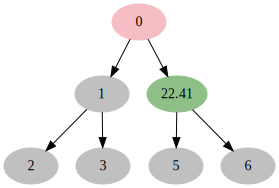

In [29]:
envs[0].render()

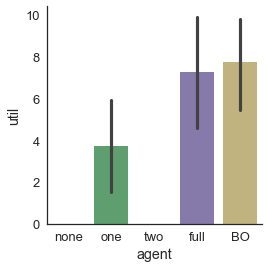

In [30]:
def data():
    policies = {
        'BO': MouselabPolicy(result.x),
        # 'wppl': MouselabPolicy([ -0.034821394751660226, 4.177078845688222, 
        # 1.216868835535616, 6.726366072163112, -1.1604972774449753 ]),
        'full': FixedPlanPolicy(range(1, TERM+1)),
        'none': FixedPlanPolicy([TERM]),
        # 'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
        # 'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
        'one': FixedPlanPolicy([1, 4, TERM]),
        # 'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
    }
    def dfs():
        eval_envs = make_envs(1, 100)
        for name, policy in policies.items():
            df = evaluate(policy, envs=make_envs(1))
            df['agent'] = name
            # print('======= {} ======='.format(name))
            # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
            # print('Return: {:.3f}'.format(df.util.mean() / sigma))
            yield df
    return pd.concat(dfs())
    
df = data()
# big_df = pd.concat([df] * 50)
sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

In [23]:
print(envs[0].reward)

Categorical(vals=[-20. -12.  -4.   4.  12.  20.], probs=[ 0.055  0.157  0.288  0.288  0.157  0.055])


In [ ]:
sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

In [86]:
empirical = df.query('agent == "BO"').util
# print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

empirical ~ $N(14.9, 14.9^2)$


In [26]:
empirical = df.query('agent == "BO"').util
print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

BO = 14.1
empirical ~ $N(12.0, 11.9^2)$


12.425000000000001

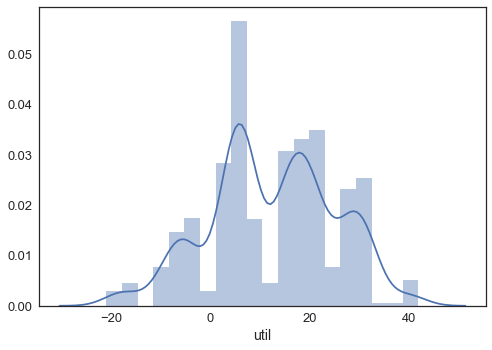

In [62]:
sns.distplot(df.query('agent == "BO"').util)
df.query('agent == "BO"').util.mean()

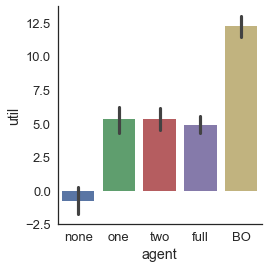

In [12]:
sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')